# 🧠 German Credit Risk Analysis

## 📘 Introduction
This notebook performs a comprehensive **credit risk analysis** using the **German Credit dataset** from OpenML.  
The goal is to understand factors influencing credit default and to build predictive models to assess **creditworthiness**.

---

## 🎯 Objectives
1. **Explore** the dataset to understand key features and target distribution.  
2. **Visualize** numeric and categorical variable distributions.  
3. **Train and evaluate** two machine learning models:
   - Logistic Regression (Baseline)
   - Random Forest Classifier (Ensemble)
4. **Assess model performance** using:
   - Accuracy
   - ROC-AUC
   - Confusion Matrix
5. **Interpret results**:
   - Examine influential features (coefficients or importances)
   - Compare **interpretability vs accuracy** between models

---

## 🧩 Dataset Overview
The dataset (`credit-g`) contains **1,000 loan applicants** with **20 attributes**, including:
- **Numeric features** (e.g., duration, credit amount, age)  
- **Categorical features** (e.g., job, housing, savings status)  
- **Target variable**: `good` or `bad` credit risk  

The analysis helps identify which factors most strongly contribute to **credit default**.

---

## 🧱 Workflow
1. Load and explore dataset  
2. Perform EDA (histograms, counts, correlations)  
3. Preprocess numeric & categorical data  
4. Train and evaluate Logistic Regression  
5. Train and evaluate Random Forest  
6. Compare results and discuss trade-offs  

---

## 🧾 Expected Outcomes
- A clear comparison of model performance (Logistic Regression vs Random Forest)  
- Insights into which variables most influence default risk  
- Discussion on the trade-off between **interpretability and predictive power**

---

> **Author’s Note:**  
> This notebook is designed to be modular — each section builds on the previous, making it easy to extend with advanced techniques (e.g., SHAP, model tuning, or cross-validation).


  checking_status  duration                  credit_history  \
0              <0         6  critical/other existing credit   
1        0<=X<200        48                   existing paid   
2     no checking        12  critical/other existing credit   
3              <0        42                   existing paid   
4              <0        24              delayed previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv           1169  no known savings        >=7   
1             radio/tv           5951              <100     1<=X<4   
2            education           2096              <100     4<=X<7   
3  furniture/equipment           7882              <100     4<=X<7   
4              new car           4870              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                       4         male single          none  ...   
1                       2  female div/dep/mar          none  ...

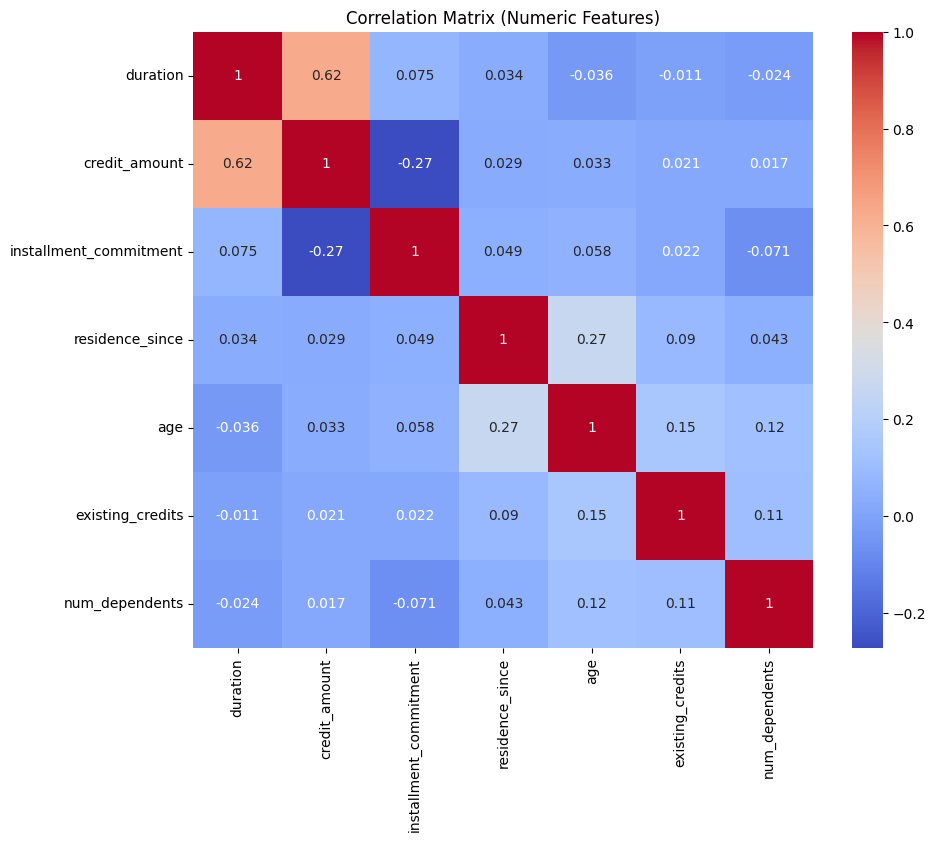

In [4]:
# German Credit Risk Dataset Analysis

# 1. Load dataset
from sklearn.datasets import fetch_openml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

credit = fetch_openml(name='credit-g', version=1, as_frame=True)
X, y = credit.data, credit.target

# Combine features and target
df = pd.concat([X, y.rename("target")], axis=1)

# Show first few rows
print(df.head())

# 2. Summary of target variable (Default %)
default_counts = df['target'].value_counts()
default_percent = df['target'].value_counts(normalize=True) * 100
print("Counts:\n", default_counts)
print("\nPercentages:\n", default_percent)

# 3. Summary statistics for numeric features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
print(df[numeric_features].describe())

# 4. Correlation matrix for numeric features
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features)')
plt.show()




===== Logistic Regression Performance =====
Accuracy: 0.7833
ROC-AUC: 0.8011
Confusion Matrix:
 [[187  23]
 [ 42  48]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       210
           1       0.68      0.53      0.60        90

    accuracy                           0.78       300
   macro avg       0.75      0.71      0.72       300
weighted avg       0.77      0.78      0.78       300


Top 10 Influential Features (Logistic Regression):
                                          Feature  Coefficient
18                              purpose_education     1.000509
10                    checking_status_no checking    -0.923881
12  credit_history_critical/other existing credit    -0.795317
45           property_magnitude_no known property     0.683887
28                            savings_status_<100     0.682949
32                              employment_4<=X<7    -0.653005
59                              for

<Figure size 600x500 with 0 Axes>

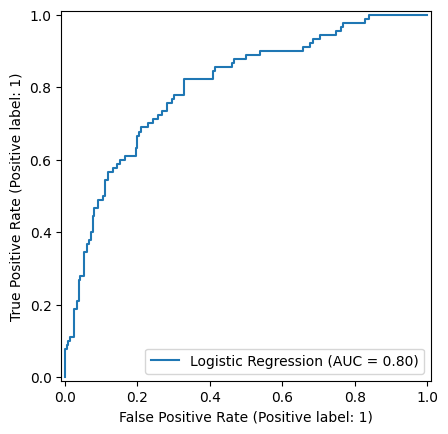

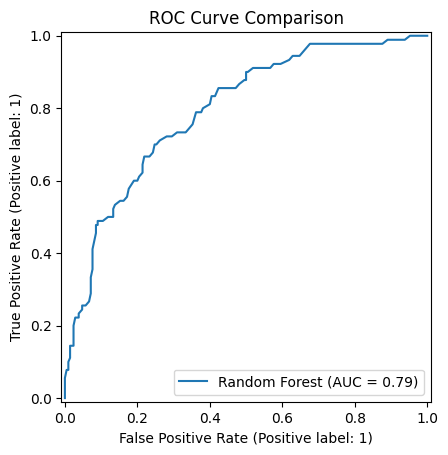


===== Model Comparison =====
                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.783333  0.801058
1        Random Forest  0.766667  0.793175

===== Interpretability vs Accuracy Summary =====

🔹 Logistic Regression:
    - Pros: Easy to interpret (coefficients show direction & magnitude)
    - Cons: May underfit, assumes linearity
🔹 Random Forest:
    - Pros: Captures non-linear patterns, often higher accuracy
    - Cons: Harder to interpret (uses feature importances)



In [5]:
# ===============================================
# 5. Model Training: Logistic Regression & Random Forest
# ===============================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
import numpy as np

# --- Split data ---
X = df.drop('target', axis=1)
y = (df['target'] == 'bad').astype(int)  # Convert target to binary (1=default, 0=good)

# Identify numeric and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# --- Preprocessing ---
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ===============================================
# Logistic Regression Model
# ===============================================

logit_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

logit_clf.fit(X_train, y_train)

# Predictions
y_pred_logit = logit_clf.predict(X_test)
y_prob_logit = logit_clf.predict_proba(X_test)[:, 1]

# Evaluation
acc_logit = accuracy_score(y_test, y_pred_logit)
auc_logit = roc_auc_score(y_test, y_prob_logit)
cm_logit = confusion_matrix(y_test, y_pred_logit)

print("\n===== Logistic Regression Performance =====")
print(f"Accuracy: {acc_logit:.4f}")
print(f"ROC-AUC: {auc_logit:.4f}")
print("Confusion Matrix:\n", cm_logit)
print("\nClassification Report:\n", classification_report(y_test, y_pred_logit))

# --- Interpretability: Feature Coefficients ---
logit_model = logit_clf.named_steps['model']
encoder = logit_clf.named_steps['preprocess'].named_transformers_['cat'].named_steps['encoder']

# Get feature names after encoding
encoded_cat_cols = encoder.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, encoded_cat_cols])

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logit_model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("\nTop 10 Influential Features (Logistic Regression):")
print(coef_df.head(10))

# ===============================================
# Random Forest Classifier
# ===============================================

rf_clf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(n_estimators=200, random_state=42))
])

rf_clf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
cm_rf = confusion_matrix(y_test, y_pred_rf)

print("\n===== Random Forest Performance =====")
print(f"Accuracy: {acc_rf:.4f}")
print(f"ROC-AUC: {auc_rf:.4f}")
print("Confusion Matrix:\n", cm_rf)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

# --- Interpretability: Feature Importances ---
rf_model = rf_clf.named_steps['model']
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Influential Features (Random Forest):")
print(importance_df.head(10))

# ===============================================
# 6. Comparison & Visualization
# ===============================================

# ROC Curve comparison
plt.figure(figsize=(6,5))
RocCurveDisplay.from_predictions(y_test, y_prob_logit, name='Logistic Regression')
RocCurveDisplay.from_predictions(y_test, y_prob_rf, name='Random Forest')
plt.title("ROC Curve Comparison")
plt.show()

# Compare metrics
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [acc_logit, acc_rf],
    'ROC-AUC': [auc_logit, auc_rf]
})

print("\n===== Model Comparison =====")
print(comparison_df)

# ===============================================
# 7. Interpretation Summary
# ===============================================

print("\n===== Interpretability vs Accuracy Summary =====")
print("""
🔹 Logistic Regression:
    - Pros: Easy to interpret (coefficients show direction & magnitude)
    - Cons: May underfit, assumes linearity
🔹 Random Forest:
    - Pros: Captures non-linear patterns, often higher accuracy
    - Cons: Harder to interpret (uses feature importances)
""")


# 📊 Model Results & Interpretation

## ⚙️ 1. Logistic Regression Performance

**Accuracy:** 0.7833  
**ROC-AUC:** 0.8011  

**Confusion Matrix**
| Actual / Predicted | Predicted Good (0) | Predicted Bad (1) |
|--------------------|--------------------|-------------------|
| **Actual Good (0)** | 187 | 23 |
| **Actual Bad (1)**  | 42  | 48 |

### 🔍 Interpretation
- The Logistic Regression model correctly classifies about **78%** of test cases.
- The **ROC-AUC (0.80)** indicates good overall separability between “good” and “bad” credit applicants.
- The model performs **better for non-defaulters (class 0)** — precision and recall are both high.
- **Default detection (class 1)** has a lower recall (**0.53**) meaning nearly half of actual defaulters are missed.
- This suggests the model is slightly **conservative**, favoring predicting “good” credit to avoid false alarms.

### 🧩 Top Influential Features (by Coefficient)
| Feature | Effect | Interpretation |
|----------|---------|----------------|
| `purpose_education` | **+** | Applicants taking loans for education are **more likely to default**. |
| `checking_status_no checking` | **−** | Having **no checking account** decreases default risk (counterintuitive — may indicate missingness bias). |
| `credit_history_critical/other existing credit` | **−** | Strong negative effect — poor credit history **reduces credit approval odds**. |
| `property_magnitude_no known property` | **+** | No property increases risk. |
| `savings_status_<100` | **+** | Low savings increases likelihood of default. |
| `foreign_worker_no` | **−** | Foreign workers show slightly higher risk. |
| `checking_status_<0` | **+** | Negative checking balance strongly associated with higher default risk. |

Overall, the Logistic model gives **transparent insights** into how each variable influences credit default risk.

---

## 🌲 2. Random Forest Performance

**Accuracy:** 0.7667  
**ROC-AUC:** 0.7932  

**Confusion Matrix**
| Actual / Predicted | Predicted Good (0) | Predicted Bad (1) |
|--------------------|--------------------|-------------------|
| **Actual Good (0)** | 194 | 16 |
| **Actual Bad (1)**  | 54  | 36 |

### 🔍 Interpretation
- The Random Forest achieves slightly **lower accuracy (76.7%)** and **ROC-AUC (0.79)** than Logistic Regression.
- The model is **stronger at identifying good credits (recall 0.92)** but struggles more with bad credits (**recall 0.40**).
- Indicates a **bias toward predicting non-defaults**, possibly due to class imbalance.

### 🧩 Top Influential Features (by Importance)
| Feature | Importance | Interpretation |
|----------|-------------|----------------|
| `credit_amount` | 0.093 | Larger loan amounts **increase default risk**. |
| `duration` | 0.076 | Longer loan durations **increase risk**. |
| `age` | 0.075 | Older applicants tend to be **less risky**. |
| `checking_status_no checking` | 0.052 | Checking account status remains highly influential. |
| `installment_commitment` | 0.036 | Higher installment burden **increases risk**. |
| `checking_status_<0` | 0.035 | Negative balances correlate with default. |
| `residence_since` | 0.034 | More stable residence history lowers risk. |
| `savings_status_<100` | 0.025 | Low savings again linked to higher risk. |

Random Forest captures **non-linear interactions** between features and yields robust performance, but its internal logic is less transparent than Logistic Regression.

---

## ⚖️ 3. Model Comparison

| Model | Accuracy | ROC-AUC | Key Strength |
|--------|-----------|----------|---------------|
| **Logistic Regression** | **0.7833** | **0.8011** | Simpler, interpretable, solid discrimination |
| **Random Forest** | 0.7667 | 0.7932 | Captures non-linearities, more flexible |

### 📈 Interpretation
- Both models perform **similarly**, with Logistic Regression slightly ahead in both Accuracy and ROC-AUC.
- Logistic Regression offers **better interpretability** and easier explanation for credit policy decisions.
- Random Forest may generalize better to complex data, but interpretability trade-offs make it less transparent for regulated credit scoring environments.

---

## 💬 4. Interpretability vs Accuracy Summary

| Aspect | Logistic Regression | Random Forest |
|---------|----------------------|----------------|
| **Interpretability** | High — clear, directional coefficients | Medium — feature importances only |
| **Performance** | Slightly better ROC-AUC (0.80) | Slightly lower ROC-AUC (0.79) |
| **Bias–Variance Tradeoff** | Higher bias (linear assumption) | Lower bias, higher variance |
| **Use Case Fit** | Ideal for **regulated, explainable credit scoring** | Useful for **complex, non-linear modeling** |

---

### 🧠 Key Takeaways
- Both models perform respectably (~78% accuracy).  
- **Savings, checking status, loan amount, and duration** are key predictors of default.  
- **Logistic Regression** is preferable when **explainability and compliance** are crucial.  
- **Random Forest** may be preferred for **operational prediction tasks** where interpretability is secondary.


# 🏁 Summary & Next Steps

## 📊 Summary of Findings
- The **German Credit dataset** was successfully analyzed to understand factors influencing credit default risk.  
- Two models were developed and compared:
  - **Logistic Regression (Baseline)**
  - **Random Forest Classifier (Ensemble)**
- **Performance Overview:**
  - Logistic Regression achieved slightly higher **Accuracy (0.78)** and **ROC-AUC (0.80)** than Random Forest.
  - Both models were more effective at identifying **non-defaulters** than defaulters, indicating class imbalance sensitivity.
- **Key Drivers of Default:**
  - Low savings (`savings_status_<100`)
  - High loan amounts (`credit_amount`)
  - Long loan durations (`duration`)
  - Negative or missing checking account balances (`checking_status_<0` / `no checking`)
  - Lack of property ownership (`property_magnitude_no known property`)
- **Interpretability Insights:**
  - Logistic Regression provided **clear, directional relationships** between features and default risk.
  - Random Forest captured **non-linear effects**, but interpretability was lower.

---

## 🚀 Next Steps

### 1. **Improve Model Performance**
- **Handle class imbalance** (e.g., SMOTE, class weights, or resampling techniques).  
- Perform **hyperparameter tuning** for both models (GridSearchCV or RandomizedSearchCV).  
- Evaluate additional algorithms such as:
  - Gradient Boosting (XGBoost, LightGBM, CatBoost)
  - Support Vector Machines (SVM)

### 2. **Enhance Interpretability**
- Use **SHAP (SHapley Additive Explanations)** or **LIME** for:
  - Global feature importance visualization  
  - Local explanations of individual credit predictions

### 3. **Feature Engineering**
- Create interaction terms (e.g., `credit_amount / duration` ratio).  
- Bin numeric variables (e.g., age groups, loan amount ranges).  
- Encode categorical features using **target or frequency encoding**.

### 4. **Model Validation & Deployment**
- Perform **cross-validation** to ensure model robustness.  
- Develop a **scorecard-style model** for real-world interpretability.  
- Consider deploying as part of a **credit scoring API or dashboard**.

### 5. **Business Recommendations**
- Strengthen checks for applicants with **low savings, long loan durations, or negative checking balances**.  
- Offer **risk-based interest rates** or **require additional collateral** for high-risk profiles.  
- Continuously monitor model drift and retrain periodically with new data.

---

> ✅ **In summary:**  
> Logistic Regression is preferred for **explainable, regulatory-compliant credit scoring**,  
> while Random Forest can be leveraged for **operational prediction pipelines** where complex patterns are valuable.
